#### Tutorial Joint Final Project: Deep Learning and Quantum Information Theory

### Quantum Code Generation using Conditional RNNs
_Yoav Rabinovich, December 2019_

--------------------------

For this final project I trained Conditional RNNs to generate quantum algorithms based on a specified target state for an $n$-qubit circuit.

#### Background: Quantum Computing


Quantum computers employ a gate model of computing, analogous to bitwise operations on a bitstring: From a set of $n$-qubits initialized to state 0, we get to a target state for the system by applying gates on one or two qubits at a time.

**Statespace**: Unlike the state of a bitstring, which can be described by definition using $n$ bits, an $n$-qubit system is described by a set complex amplitudes that correspond to the probabilities to measure the system in any configuration of $n$ bits, leading to a statespace of $2^n$ complex numbers, or $2^{n+1}$ floats. These complex amplitudes are achieved through the ability of qubits to be put into superpositions of the 0 and 1 computational states, as well as the ability of two qubits to be entangled, such that the state describing their 2-qubit system is not separable into two 1-qubit states. However, this is not pertinent to explain our implementation.

**Gates:** There are infinitely many sets of possible gates that can map the initial state into any state in the statespace of an $n$-qubit system. For this implementation, I made a choice of set, but in principle the model can be trained for any set of gates. The gates included in this implementation are the $H$ gate, which puts qubits in and out of superpositions of computational states; the $S$ gate which shifts superpositions but doesn't act on computational states; and the $CNOT$ gate which puts pairs of qubits into entangled states by flipping one target qubit depending on the state of another control qubit.

**QisKit:** Using IBM's QisKit API, along with the QASM format for circuit specification, we are able to both sample random circuits by sampling gates and attaching them to random qubits in a sequence, and to simulate circuits to find the output states they yield when fed an initialized state.

#### Background: Deep Learning


**RNNs:** Recurrent neural networks generate a language-model for a dataset of sequences, learning to predict the next element in a sequence given the preceding elements in a computationally parallelizable way. In a stacked (or "deep") RNN model, RNN layers are fed into each other in a sequence, each layer containing several computational units. These units, such as the GRU used in this implementation, can learn to retain important information about the long-range structure of sequences, allowing them to draw on the entire preceding sequence to generate a prediction.

**Conditional RNNs:** However, RNNs lack a mechanism by which to consider non-temporal information in the correlations they learn. A conditional RNN attemps to force the network to output different predictions based on conditions external to the preceding sequence. There are three overall schemes to construct "conditional" RNNs in the literature:

1. Have the first timestep contain conditioning data, to set the internal state of your RNN. This is similar to what happens in encoder-decoder networks, which encode sequences into an input element which is then interepreted by a dedicated decoder, which is a "stateful" RNN, feeding the prediction of a cell as input to the next until an end-of-sentece token is predicted. However, this restricts the conditioning data to the shape of an element in the sequence, and also doesn't guarantee that the network retains the information as prediction continues.

2. Append the condition to the temporal input, such that each feature vector includes both the time series data and a constant condition vector. However, this approach pollutes the data and requires the network to learn the two different types of correlations itself, which is inefficient.

3. Finally, we can directly affect the intenral state of the RNN at time zero. For each training sample, we apply a dense layer to reshape the condition data into the right shape as the internal state of the RNN, and for the first timestep, we add the result to the internal state of the RNN directly. This cannot be implemented naturally with Keras, so I found a package that implements this behavior in Tensorflow.

#### Method

I train the model to predict the next gate in a circuit given previous gates, and given an external condition set to an output state of the circuit. This way, I hope to be able to input a target state as a condition for the trained network to generate a circuit that will reach it.

I have built two similar models, with a difference only in the circuit encodig scheme: One has the gates encoded as integers indexing a vocabulary, while the other has the integers translated to one-hot encoding first. The latter seems preferable, since it doesn't posit any linear relationship between elements close to each other in the vocabulary, but unfortunately neither performed well under the conditions they were trained.

**Data Synthesis:** I use QisKit to sample a dataset of random $n$-qubit circuits of a chosen length, and encode them in a vocabulary scheme described in the code comments, such that every possible gate application on any qubit is encoded with a different index. I then simulate each circuit to produce output states to use as conditions while training. To train the network to predict the next gate in a sequence, I simply offset the input dataset by one gate to create the target dataset.

**Model Structure:**
The inputs are fed into a stacked Conditional RNN with GRU units, the outputs of which are then passed through a Dense layer for classification and prediction. In the case of the integer encoding, the model's optimized according to mean squared error loss, and under the one-hot scheme I use cross-entropy.

**Results:** Both models learn the rules regarding "end-of-sequence" and padding tokens very quickly, but the training is slow and the results are bad. As expected, the one-hot encoded model performs better than the integer scheme, and when its outputs are simulated seems to be able to match some of the target amplitudes in the condition state, but the model only outputs very simple circuits that don't include $CNOT$ gates which are essential for universal computation. In fact, this means the model ignores most of the entire vocabulary available to it. This might be solved by longer training, but I can't confirm this.



#### Next Steps

I hoped that the conditional RNN layers would be able to learn correlations between the conditions and sequences of applied gates, since the elements in the sequence were sampled uniformly and independently of each other and should result in no information for the model to use other than the condition-sequence correlations. However, this is a problem where the space of sequences is much larger than the space of condition states, which might confuse the network. A dataset of more intelligently constructed algorithms might also teach the network some best-practices that will help it converge on a correct sequence.

Another avenue to explore is models with the ability to asses their progress towards their goal as they predict elements of the sequence: where the loss function is derived from the output of the sequence constructed. However, simulating quantum computers, while deterministic, requires the use of external packages employing numerical models, which is not differentiable. Other than rewriting a differentiable Quantum simulator in TensorFlow, I could turn instead to reinforcement learning. I stayed away from this avenus since I was afraid that simulation during each step in the training will take to long to be feasible, but in the long run it might be a profitable path to take.

#### Installs and imports

In [0]:
!pip install qiskit
!pip install tensorflow-gpu --upgrade
!pip install cond_rnn

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit as qk
qs_backend = qk.Aer.get_backend('statevector_simulator')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import cond_rnn as crnn
import re

#### Preprocessing and Postprocessing

In [0]:
def sample_circuits(n,size,amount):
    """Sample an amount of random n-qubit circuits with a certain size in
    number of operations from the allowed set"""

    circuits =[]
    for _ in range(amount):
        # Create circuit object of n qubits
        circ = qk.QuantumCircuit(n)
        # Generate random gates on random qubits from the universal set {H,S,CX}
        for _ in range(size):
            gate = np.random.randint(0,3)
            target = np.random.randint(0,n)
            if gate==0: # Hadamard
                circ.h(target)
            if gate==1: # S-gate
                circ.s(target)
            if gate==2: # CNOT
                control = np.random.randint(0,n)
                if control == target:
                    circ.h(target)
                else:
                    circ.cx(control,target)
        circuits.append(circ)
    return circuits

def generate_labels(circuits,encoded=True):
    """Simulate each in an array of circuits, and return the resultant state.
    The state can be encoded as an array of size 2*(2^n) where the real and imaginary
    components of each amplitude are concatenated."""

    global qs_backend
    labels=[]
    for circ in circuits:
        # Simulate each circuit and retrieve final quantum state
        job = qk.execute(circ, qs_backend)
        outputstate = job.result().get_statevector(circ, decimals=3)
        if encoded:
            # encode complex amplitudes as flattened arrays
            separated = []
            separated.append(outputstate.real)
            separated.append(outputstate.imag)
            outputstate = separated
        labels.append(np.array(outputstate).flatten())
    return np.array(labels)

def encode_circuits(circuits,n,max_size,label=True):
    """Takes an array of n-qubit QuantumCircuit objects, and encodes them based on a
    vocabulary of possible gates to apply, including tokens to signify the start
    and end of sequences. Elements after EoS are padded to match maximum circuit
    size using a special token.
    Labels can be also be generated for the circuits."

    Vocabulary scheme:
    Padding = 0,
    SoS = 1,
    EoS = 2,
    h[0]=3, h[1]=3+1...
    s[0]=3+n, s[1]=3+n+1...
    cx[0,0]=3+2n, cx[0,1]=3+2n+1...
    cx[1,0]=3+(2+1)n, cx[1,1]=3+(2+1)n+1... etc. """

    encoded = []
    for circ in circuits:
        # Use the QASM format to convert the circuit to a string
        lines = circ.qasm().splitlines()[3:]
        size = len(lines)
        # Initialize to padding tokens
        encoded_circ = np.zeros(max_size+2)
        # Add SoS and EoS tokens
        encoded_circ[0] = 1
        encoded_circ[size+1]=2
        for i,line in enumerate(lines):
            # Detect gate name and qubits involved
            gate_str = line[:2]
            integers = [int(s) for s in re.findall(r'-?\d+\.?\d*',line)]
            # Encode gates based on scheme above
            if gate_str=="h ":
                encoded_circ[i+1]=int(3+integers[0])
            if gate_str=="s ":
                encoded_circ[i+1]=int(3+n+integers[0])
            if gate_str=="cx":
                encoded_circ[i+1]=int(3+(2+integers[0])*n+integers[1])
        encoded.append(encoded_circ)
    encoded = np.array(encoded)
    if label:
        # Simulate labels for each circuit and attach to dataset
        labels = generate_labels(circuits)
        return np.concatenate((encoded,labels),axis=1)
    else:
        return np.array(encoded)

def decode_circuit(encoded,n):
    """Takes an encoded output from the network and generates the corresponding
    circuit as described above."""

    # Start with opening syntax
    decoded = "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q["+str(n)+"];\n"
    for line in encoded:
        # decode each non-token element into its QASM string
        line = int(line)
        if line > 2:
            gate_num = int(np.ceil((line-2)/n))
            if gate_num==1:
                decoded += "h q["+str(line-3)
            elif gate_num==2:
                decoded += "s q["+str(line-n-3)
            else:
                decoded += "cx q["+str(gate_num-3)+"],q["+str(line-(gate_num-1)*n-3)
            decoded += "];\n"
        if line == 2:
            decoded = decoded[:-1]
    # print(decoded)
    # Build circuit object from QASM string
    return qk.QuantumCircuit.from_qasm_str(decoded)

#### Demonstration

We demonstrate our ability to sample algorithms of arbitrary dimensions, encode them correctly using our vocabulary scheme, and decode them exactly to their original circuit objects (up to allowable swaps in non-interacting gates).

In [0]:
n = 10
max_size = 30

# Sample, Encode and Label circuits
sampled_circuits = sample_circuits(n, max_size, 20)
encoded_circuits = encode_circuits(sampled_circuits, n, max_size, label=False)
labels = generate_labels(sampled_circuits, encoded=True)

In [0]:
# Graph sample circuit
samp = sampled_circuits[0]
samp.draw()

In [0]:
# Present QASM string and encoded representation
print(samp.qasm())
enc = encoded_circuits[0]
print(enc)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[10];
s q[6];
h q[4];
h q[9];
cx q[6],q[4];
cx q[8],q[6];
h q[2];
h q[3];
h q[0];
h q[5];
s q[4];
h q[1];
cx q[9],q[0];
h q[5];
h q[7];
cx q[4],q[2];
s q[0];
s q[2];
s q[9];
h q[6];
s q[6];
h q[1];
cx q[4],q[6];
s q[2];
s q[0];
h q[8];
s q[9];
cx q[9],q[4];
h q[4];
s q[4];
h q[1];

[  1.  19.   7.  12.  87. 109.   5.   6.   3.   8.  17.   4. 113.   8.
  10.  65.  13.  15.  22.   9.  19.   4.  69.  15.  13.  11.  22. 117.
   7.  17.   4.   2.]


In [0]:
# Decode the encoded representation and graph it to demonstrate similarity
dec = decode_circuit(enc,n)
dec.draw()

#### Vocabulary Circuit Model

In [0]:
# Model Parameters
N = 5
VOCAB_DIM = 2+2*N+N**2
NUM_SAMPLES = 100000
TRAINTEST = 0.75
CUTOFF = int(NUM_SAMPLES//2)#(1/TRAINTEST))
MAX_LENGTH = 10
TIME_STEPS = MAX_LENGTH+2
INPUT_DIM = 1
COND_DIM = 2*(2**N)
NUM_CELLS = 256
STACK_DEPTH = 5
PRINT_DELAY = 100
SAVE_DELAY = 10000

# Training Parameters
BATCH_SIZE = 32
EPOCHS = 1000000

In [0]:
# Generate Data
# Data = encode_circuits(sample_circuits(N,MAX_LENGTH,NUM_SAMPLES),N,MAX_LENGTH,label=True)
# Save Data
# np.savetxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", Data, delimiter=",")
# Load Data
# Data = np.loadtxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", delimiter=",")
np.random.shuffle(Data)
X = Data[:,:TIME_STEPS]
X = X.reshape((X.shape[0],X.shape[1],1))
c = Data[:,TIME_STEPS:]
offset = X[:,1:]
y = np.concatenate((offset,np.zeros((X.shape[0],1,1))),axis=1)
X_train = X[:CUTOFF]
X_test = X[CUTOFF:]
c_test = c[:CUTOFF]
c_train = c[CUTOFF:]
y_train = y[:CUTOFF]
y_test = y[CUTOFF:]

In [0]:
sess = tf.Session()

# Placeholders.
inputs = tf.placeholder(name='inputs', dtype=tf.float32, shape=(None, TIME_STEPS, INPUT_DIM))
targets = tf.placeholder(name='targets', dtype=tf.float32, shape=(None, TIME_STEPS, INPUT_DIM))
cond = tf.placeholder(name='conditions', dtype=tf.float32, shape=(None, COND_DIM))

# Conditional RNN.
outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)
for _ in range(STACK_DEPTH-1):
    outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)

# Classification layer.
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1, activation='relu'))(outputs)

# Loss + Optimizer.
cost = tf.reduce_sum(tf.reduce_mean(tf.squared_difference(outputs, targets)))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Initialize variables (tensorflow)
sess.run(tf.global_variables_initializer())

# Define the binding between placeholders and real data.
train_feed_dict = {inputs: X_train, targets: y_train, cond: c_train}
test_feed_dict = {inputs: X_test, targets: y_test, cond: c_test}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Main loop. Optimize then evaluate.
saver = tf.train.Saver()
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    sess.run(optimizer, train_feed_dict)
    if epoch % PRINT_DELAY == 0:
        train_outputs, train_loss = sess.run([outputs, cost], train_feed_dict)
        test_outputs, test_loss = sess.run([outputs, cost], test_feed_dict)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'[{str(epoch).zfill(4)}] train cost = {train_loss:.4f}, test cost = {test_loss:.4f}.')
    if epoch % SAVE_DELAY == 0:
        saver.save(sess, f'Checkpoints/QCG-{str(NUM_CELLS)}', global_step=int(epoch/SAVE_DELAY))


[0000] train cost = 173.6090, test cost = 173.7048.
[0100] train cost = 68.7404, test cost = 68.7548.
[0200] train cost = 66.8745, test cost = 66.9583.
[0300] train cost = 66.6586, test cost = 66.7598.
[0400] train cost = 66.6138, test cost = 66.7233.
[0500] train cost = 66.5873, test cost = 66.7125.
[0600] train cost = 66.5673, test cost = 66.7099.
[0700] train cost = 70.7206, test cost = 70.7812.
[0800] train cost = 67.2028, test cost = 67.2783.
[0900] train cost = 66.7442, test cost = 66.8253.
[1000] train cost = 66.6275, test cost = 66.7237.
[1100] train cost = 66.5869, test cost = 66.6958.
[1200] train cost = 66.5700, test cost = 66.6900.
[1300] train cost = 66.5602, test cost = 66.6912.
[1400] train cost = 66.5518, test cost = 66.6949.
[1500] train cost = 75.5182, test cost = 75.6060.
[1600] train cost = 66.6130, test cost = 66.7421.
[1700] train cost = 66.5618, test cost = 66.7066.
[1800] train cost = 66.5470, test cost = 66.7045.
[1900] train cost = 66.5366, test cost = 66.7071

KeyboardInterrupt: ignored

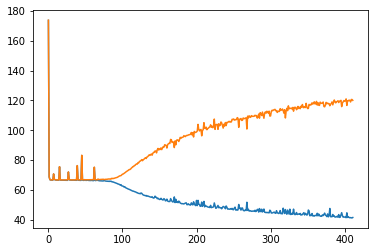

In [0]:
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(test_losses)),test_losses)

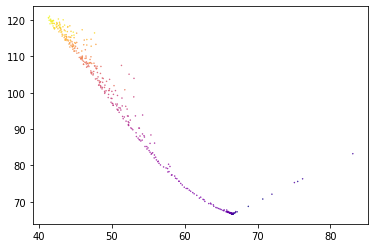

In [0]:
plt.scatter(train_losses[1:],test_losses[1:],s=0.2,c=range(len(train_losses))[1:],cmap="plasma")

In [0]:
examples, example_loss = sess.run([outputs, cost], train_feed_dict)#{inputs:X_train[[0]],targets:y_train[[0]],cond:c_train[[0]]})

In [0]:
i=np.random.randint(test_outputs.shape[0])
examples = np.around(examples)
print(examples[i].T)
print(y_train[i].T)


[[20. 10. 16.  7.  7.  8.  8.  5.  8.  6.  1.  0.]]
[[20.  6. 10.  6.  6.  9. 12.  5.  9.  5.  2.  0.]]


In [0]:
encoded = np.concatenate((np.array([1]),examples[i].flatten()[:-2],np.array([2])))
print(encoded)
example_circ = decode_circuit(encoded,N)
example_circ.draw()

[ 1. 20. 10. 16.  7.  7.  8.  8.  5.  8.  6.  2.]
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
cx q[1],q[2];
s q[2];
cx q[0],q[3];
h q[4];
h q[4];
s q[0];
s q[0];
h q[2];
s q[0];
h q[3];


In [0]:
label = generate_labels([example_circ])
print(label)
print(c_train[i])

[[ 0.5  0.   0.   0.   0.5  0.   0.   0.   0.5  0.   0.   0.   0.5  0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  -0.   0.   0.   0.  -0.   0.   0.   0.  -0.   0.
   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. ]]
[ 0.354  0.     0.354  0.     0.     0.     0.     0.     0.     0.
  0.     0.    -0.354  0.    -0.354  0.     0.354  0.     0.354  0.
  0.     0.     0.     0.     0.     0.     0.     0.    -0.354  0.
 -0.354  0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.   ]


#### OHE Circuit Model

In [0]:
# Model Parameters
N = 5
VOCAB_DIM = 2+2*N+N**2
NUM_SAMPLES = 100000
TRAINTEST = 0.75
CUTOFF = int(NUM_SAMPLES//2)#(1/TRAINTEST))
MAX_LENGTH = 10
TIME_STEPS = MAX_LENGTH+2
COND_DIM = 2**(N+1)
NUM_CELLS = 256
STACK_DEPTH = 5
PRINT_DELAY = 100
SAVE_DELAY = 10000

# Training Parameters
BATCH_SIZE = 32
EPOCHS = 1000000

In [0]:
# Generate Data
# Data = encode_circuits(sample_circuits(N,MAX_LENGTH,NUM_SAMPLES),N,MAX_LENGTH,label=True)
# Save Data
# np.savetxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", Data, delimiter=",")
# Load Data
Data = np.loadtxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", delimiter=",")
np.random.shuffle(Data)
X = Data[:,:TIME_STEPS]
# Convert to onehot
X = np.array([[eye[int(gate)] for gate in X[int(row),:]] for row in range(X.shape[0])])
c = Data[:,TIME_STEPS:]
offset = X[:,1:]
y = np.concatenate((offset,np.zeros((X.shape[0],1,VOCAB_DIM))),axis=1)
X_train = X[:CUTOFF]
X_test = X[CUTOFF:]
c_test = c[:CUTOFF]
c_train = c[CUTOFF:]
y_train = y[:CUTOFF]
y_test = y[CUTOFF:]

In [0]:
sess = tf.Session()

# Placeholders.
inputs = tf.placeholder(name='inputs', dtype=tf.float32, shape=(None, None, VOCAB_DIM))
targets = tf.placeholder(name='targets', dtype=tf.float32, shape=(None, None, VOCAB_DIM))
cond = tf.placeholder(name='conditions', dtype=tf.float32, shape=(None, COND_DIM))

# Conditional RNN.
outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)
for _ in range(STACK_DEPTH-1):
    outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)

# Classification layer.
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=VOCAB_DIM, activation='softmax'))(outputs)

# Loss + Optimizer.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Initialize variables (tensorflow)
sess.run(tf.global_variables_initializer())

# Define the binding between placeholders and real data.
train_feed_dict = {inputs: X_train, targets: y_train, cond: c_train}
test_feed_dict = {inputs: X_test, targets: y_test, cond: c_test}

In [0]:
# Main loop. Optimize then evaluate.
#saver = tf.train.Saver()
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    sess.run(optimizer, train_feed_dict)
    if epoch % PRINT_DELAY == 0:
        train_outputs, train_loss = sess.run([outputs, cost], train_feed_dict)
        test_outputs, test_loss = sess.run([outputs, cost], test_feed_dict)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'[{str(epoch).zfill(4)}] train cost = {train_loss:.4f}, test cost = {test_loss:.4f}.')
    if epoch % SAVE_DELAY == 0:
        saver.save(sess, f'Checkpoints/QCG-ohe-{str(NUM_CELLS)}', global_step=int(epoch/SAVE_DELAY))


[0000] train cost = 3.3097, test cost = 3.3097.
[0100] train cost = 3.1948, test cost = 3.1948.
[0200] train cost = 3.1888, test cost = 3.1886.
[0300] train cost = 3.1885, test cost = 3.1884.
[0400] train cost = 3.1884, test cost = 3.1883.
[0500] train cost = 3.1883, test cost = 3.1883.
[0600] train cost = 3.1883, test cost = 3.1883.
[0700] train cost = 3.1882, test cost = 3.1883.
[0800] train cost = 3.1881, test cost = 3.1884.
[0900] train cost = 3.1879, test cost = 3.1884.
[1000] train cost = 3.1877, test cost = 3.1885.
[1100] train cost = 3.1875, test cost = 3.1887.
[1200] train cost = 3.1872, test cost = 3.1889.
[1300] train cost = 3.1868, test cost = 3.1893.
[1400] train cost = 3.2689, test cost = 3.2713.
[1500] train cost = 3.2684, test cost = 3.2717.
[1600] train cost = 3.2676, test cost = 3.2722.
[1700] train cost = 3.2666, test cost = 3.2730.
[1800] train cost = 3.2655, test cost = 3.2739.
[1900] train cost = 3.1852, test cost = 3.1920.
[2000] train cost = 3.1820, test cost = 

KeyboardInterrupt: ignored

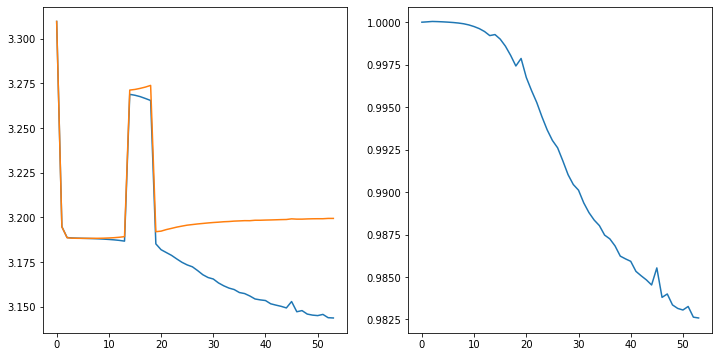

In [0]:
ts = range(len(train_losses))
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(ts,train_losses)
ax.plot(ts,test_losses)
ax1 = fig.add_subplot(122)
ax1.plot(ts,np.divide(train_losses,test_losses))
plt.show()

In [0]:
# Load model
# new_saver = tf.train.import_meta_graph('Checkpoints/QCG-ohe-256-5.meta')
# new_saver.restore(sess, tf.train.latest_checkpoint('Checkpoints'))
examples, example_loss = sess.run([outputs, cost], train_feed_dict)

In [0]:
i = np.random.randint(examples.shape[0])
ones = np.full((examples.shape[0],1),1)
vocab = np.argmax(np.around(examples),2)[:,:-1]
final = np.concatenate((ones,vocab),1)
decoded = decode_circuit(final[i],N)
label = generate_labels([decoded])
print(final[i])
print(np.concatenate(([1],np.argmax(y_train[i][:-1],1))))
print(label)
print(c_train[i])
decoded.draw()

[1 5 5 5 6 7 7 5 7 7 5 2]
[ 1  3 10  8 24  9  9 26  9 20 14  2]
[[ 0.5  0.   0.   0.   0.5  0.   0.   0.   0.5  0.   0.   0.   0.5  0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.  -0.   0.   0.   0.  -0.   0.   0.   0.  -0.   0.
   0.   0.  -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. ]]
[0.5 0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.
 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


#### Code Graveyard

Failed model: Naive RNN

In [0]:
# Parameters
n = 5
vocab_dim = 2+2*n+n**2
embedding_dim = 32
max_length = 30
batch_size = 32

In [0]:
# Data
l_m = encode_circuits(sample_circuits(n,max_length,2000),n,max_length,label=True)
l_q = encode_circuits(sample_circuits(n,int(np.ceil(max_length/4)),500),n,max_length,label=True)
l_h = encode_circuits(sample_circuits(n,int(np.ceil(max_length/2)),500),n,max_length,label=True)
l_tq = encode_circuits(sample_circuits(n,int(np.ceil(3*max_length/4)),500),n,max_length,label=True)
Data = np.concatenate((l_m,l_q,l_h,l_tq),axis=0)
np.random.shuffle(Data)
X = Data[:,32:]
y = Data[:,:32]
X_train = X[:1500]
X_test = X[1500:]
y_train = y[:1500]
y_test = y[1500:]

In [0]:
# Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_length+2,embedding_dim,mask_zero=True))
#model.add(tf.keras.layers.Masking(mask_value=0, input_shape=(max_length,)))
#model.add(tf.keras.layers.RepeatVector(max_length, input_shape=(max_length,)))
model.add(tf.keras.layers.LSTM(max_length+2, return_sequences=False))
model.add(tf.keras.layers.Dense(max_length+2, activation="softmax"))
model.compile(optimizer="Adadelta",loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, None, 32)          1024      
_________________________________________________________________
lstm_28 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
Total params: 10,400
Trainable params: 10,400
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          epochs=100)

Train on 1500 samples, validate on 500 samples
Epoch 1/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.1108 - accuracy: 0.0193 - val_loss: 794.2617 - val_accuracy: 0.0140
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.0986 - accuracy: 0.0233 - val_loss: 794.2491 - val_accuracy: 0.0260
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.0851 - accuracy: 0.0347 - val_loss: 794.2361 - val_accuracy: 0.0260
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.0718 - accuracy: 0.0440 - val_loss: 794.2226 - val_accuracy: 0.0440
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.0572 - accuracy: 0.0433 - val_loss: 794.2086 - val_accuracy: 0.0420
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/sample - loss: 794.0427 - accuracy: 0.0560 - val_loss: 794.1940 - val_accuracy: 0.0680
Epoch 7/100
1500/1500 [========================

In [0]:
model.predict(X_test)[1]

array([2.07551420e-02, 3.53694521e-02, 5.65202162e-02, 9.26227644e-02,
       1.31801024e-01, 1.92374557e-01, 2.02626482e-01, 2.44499505e-01,
       1.21816928e-02, 6.54638512e-03, 9.04475630e-04, 8.65014081e-05,
       1.11552211e-03, 8.93953547e-04, 1.12635980e-03, 5.64334448e-04,
       1.97271265e-06, 7.51783830e-07, 9.01427597e-07, 5.44743079e-06,
       4.84584291e-07, 3.19799511e-07, 7.80020173e-07, 9.12153382e-07,
       2.41702547e-09, 4.57604565e-10, 1.11226334e-10, 3.81706311e-09,
       8.70810757e-10, 1.63690728e-10, 3.51982332e-10, 1.91976812e-09],
      dtype=float32)

Old encoding, based on one-hot vectors.

In [0]:
def encode_circuits(circuits,label=True):
    """Takes a QuantumCircuit object, and generates an encoding
    for use by the network as an array of gates, where each gate is encoded in
    one-hot encoding for gate type, target qubit and control qubit.
    We also embed tokens to signify the start and end of each sequence, encoded
    as extra gate types.
    Labels can be included or excluded."""
    encoded = []
    for circ in circuits:
        lines = circ.qasm().splitlines()[2:]
        n = int(lines[0][7:-2])
        lines = lines[1:]
        size = len(lines)
        encoded_circ = []
        eye_g = np.eye(5)
        eye_n = np.eye(n)
        encoded_circ.append(eye_g[3])
        encoded_circ.append(np.zeros(n))
        encoded_circ.append(np.zeros(n))
        for line in lines:
            gate_str = line[:2]
            integers = [int(s) for s in re.findall(r'-?\d+\.?\d*',line)]
            if gate_str=="h ":
                encoded_circ.append(eye_g[0])
                encoded_circ.append(eye_n[integers[0]])
                encoded_circ.append(np.zeros(n))
            if gate_str=="s ":
                encoded_circ.append(eye_g[1])
                encoded_circ.append(eye_n[integers[0]])
                encoded_circ.append(np.zeros(n))
            if gate_str=="cx":
                encoded_circ.append(eye_g[2])
                encoded_circ.append(eye_n[integers[1]])
                encoded_circ.append(eye_n[integers[0]])
        encoded_circ.append(eye_g[4])
        encoded_circ.append(np.zeros(n))
        encoded_circ.append(np.zeros(n))
        encoded.append(encoded_circ)
    encoded = np.array(encoded)
    if label:
        labels = generate_labels(circuits)
        return np.array(encoded),labels
    else:
        return np.array(encoded)

def decode_circuit(encoded):
    """Takes an encoded output from the network and generates the corresponding
    circuit as described above."""
    decoded = "OPENQASM 2.0;\ninclude \"qelib1.inc\";\nqreg q["
    decoded += str(len(encoded[1]))+"];\n"
    encoded = [encoded[n:n+3] for n in range(0, len(encoded), 3)]
    for line in encoded:
        gate_num = np.argmax(line[0])
        target = str(np.argmax(line[1]))
        if gate_num==0:
            decoded += "h q["+target
        if gate_num==1:
            decoded += "s q["+target
        if gate_num==2:
            control = str(np.argmax(line[2]))
            decoded += "cx q["+control+"],q["+target
        if gate_num < 3:
            decoded += "];"
        if gate_num==4:
            decoded += "\n"
    return qk.QuantumCircuit.from_qasm_str(decoded)

Old loss function, uses simulation to test generated circuits.

In [0]:
# Loss Function
@tf.function
def simulation_loss(y_true,y_pred):
    # global N
    decoded = decode_circuit(y_pred,5)
    y_pred = generate_labels([decoded])[0]
    return K.mse(y_true,y_pred)

Failed Model: OHE Gate Model

In [0]:
# Model Parameters
N = 5
VOCAB_DIM = 2+2*N+N**2
NUM_SAMPLES = 1000
TRAINTEST = 0.75
CUTOFF = int(TIME_STEPS*NUM_SAMPLES//2)#(1/TRAINTEST))
MAX_LENGTH = 10
TIME_STEPS = MAX_LENGTH+2
COND_DIM = 2*(2**N)
NUM_CELLS = 256
STACK_DEPTH = 5
PRINT_DELAY = 100
SAVE_DELAY = 10000

# Training Parameters
BATCH_SIZE = 32
EPOCHS = 1000000

In [0]:
# Generate Data
#Data = encode_circuits(sample_circuits(N,MAX_LENGTH,NUM_SAMPLES),N,MAX_LENGTH,label=True)
# Save Data
# np.savetxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", Data, delimiter=",")
# Load Data
# Data = np.loadtxt(f"Encoded_Circuits_{str(N)}_{str(MAX_LENGTH)}_{str(NUM_SAMPLES)}.csv", delimiter=",")
np.random.shuffle(Data)
X = Data[:,:TIME_STEPS]
# Convert to onehot
X = np.array([[eye[int(gate)] for gate in X[int(row),:]] for row in range(X.shape[0])])
c = Data[:,TIME_STEPS:]
# Flatten
X = X.reshape((NUM_SAMPLES*TIME_STEPS,1,VOCAB_DIM))
offset = X[1:,:]
y = np.concatenate((offset,np.zeros((1,1,VOCAB_DIM))),0)
c = np.repeat(c,12,0)

X_train = X[:CUTOFF]
X_test = X[CUTOFF:]
c_test = c[:CUTOFF]
c_train = c[CUTOFF:]
y_train = y[:CUTOFF]
y_test = y[CUTOFF:]

In [0]:
sess = tf.Session()

# Placeholders.
inputs = tf.placeholder(name='inputs', dtype=tf.float32, shape=(None, 1, VOCAB_DIM))
targets = tf.placeholder(name='targets', dtype=tf.float32, shape=(None, 1, VOCAB_DIM))
cond = tf.placeholder(name='conditions', dtype=tf.float32, shape=(None, COND_DIM))

# Conditional RNN.
outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)
for _ in range(STACK_DEPTH-1):
    outputs = crnn.ConditionalRNN(NUM_CELLS, cell='GRU', cond=cond, dtype=tf.float32, return_sequences=True)(inputs)

# Classification layer.
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=VOCAB_DIM, activation='softmax'))(outputs)

# Loss + Optimizer.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Initialize variables (tensorflow)
sess.run(tf.global_variables_initializer())

# Define the binding between placeholders and real data.
train_feed_dict = {inputs: X_train, targets: y_train, cond: c_train}
test_feed_dict = {inputs: X_test, targets: y_test, cond: c_test}

In [0]:
# Main loop. Optimize then evaluate.
saver = tf.train.Saver()
train_losses = []
test_losses = []
for epoch in range(EPOCHS):
    sess.run(optimizer, train_feed_dict)
    if epoch % PRINT_DELAY == 0:
        train_outputs, train_loss = sess.run([outputs, cost], train_feed_dict)
        test_outputs, test_loss = sess.run([outputs, cost], test_feed_dict)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f'[{str(epoch).zfill(4)}] train cost = {train_loss:.4f}, test cost = {test_loss:.4f}.')
    if epoch % SAVE_DELAY == 0:
        saver.save(sess, f'Checkpoints/QCG-ohe-g-{str(NUM_CELLS)}', global_step=int(epoch/SAVE_DELAY))


[0000] train cost = 3.6105, test cost = 3.6100.
[0100] train cost = 3.4769, test cost = 3.4875.
[0200] train cost = 3.4636, test cost = 3.4891.
[0300] train cost = 3.4519, test cost = 3.4892.
[0400] train cost = 3.4413, test cost = 3.4910.
[0500] train cost = 3.4370, test cost = 3.4907.
[0600] train cost = 3.4347, test cost = 3.4908.
[0700] train cost = 3.4130, test cost = 3.4932.
[0800] train cost = 3.4036, test cost = 3.4934.
[0900] train cost = 3.3998, test cost = 3.4930.
[1000] train cost = 3.3923, test cost = 3.4940.
[1100] train cost = 3.3846, test cost = 3.4948.
[1200] train cost = 3.3804, test cost = 3.4932.
[1300] train cost = 3.3738, test cost = 3.4925.
[1400] train cost = 3.3681, test cost = 3.4922.
[1500] train cost = 3.3655, test cost = 3.4932.
[1600] train cost = 3.3596, test cost = 3.4928.
[1700] train cost = 3.3538, test cost = 3.4937.
[1800] train cost = 3.3519, test cost = 3.4938.
[1900] train cost = 3.3496, test cost = 3.4939.
[2000] train cost = 3.3456, test cost = 

KeyboardInterrupt: ignored

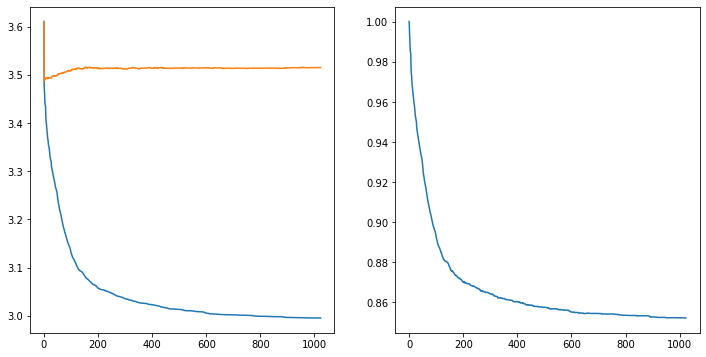

In [0]:
ts = range(len(train_losses))
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.plot(ts,train_losses)
ax.plot(ts,test_losses)
ax1 = fig.add_subplot(122)
ax1.plot(ts,np.divide(train_losses,test_losses))
plt.show()

In [0]:
examples, example_loss = sess.run([outputs, cost], train_feed_dict)

In [0]:
i = np.random.randint(examples.shape[0])
print(np.argmax(examples[i],1))
print(np.argmax(y_train[i],1))
# ones = np.full((examples.shape[0],1),1)
# vocab = np.argmax(np.around(examples),2)[:,:-1]
# final = np.concatenate((ones,vocab),1)
# decoded = decode_circuit(final[i],N)
# label = generate_labels([decoded])
# print(final[i])
# print(np.concatenate(([1],np.argmax(y_train[i][:-1],1))))
# print(label)
# print(c_train[i])
# decoded.draw()

[3]
[8]


In [0]:
example = sess.run(outputs, {inputs: [X_train[14]], cond: [c_train[14]]})
print(np.argmax(example))

12


In [0]:
saver.recover_last_checkpoints("Checkpoints")
circ = []
condition = [c_train[0]]
length = 12
ix = [1]
X = np.zeros((length,1, VOCAB_DIM))   
for i in range(length):
    X[i, 0 , ix[-1]] = 1
    circ.append(np.argmax(X[0, :]))
    if np.argmax(X[0, :]) ==2: break
    ix = np.argmax(sess.run([outputs], {inputs:  X, cond: condition})[0],1)
print(circ)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
